In [2]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# ✅ Always import from tensorflow.keras to avoid version conflicts
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json


In [3]:
CHANNELS=3

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/split-monkey-pox-dataset/Monkey split/train',
    batch_size=32,
    class_mode='categorical',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
   '/kaggle/input/split-monkey-pox-dataset/Monkey split/val',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))
test_generator = validation_datagen.flow_from_directory(
   '/kaggle/input/split-monkey-pox-dataset/Monkey split/test',
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224))

Found 4200 images belonging to 6 classes.
Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


In [5]:
x, y = next(test_generator)   # use Python's built-in next()
x.shape


(32, 224, 224, 3)

In [6]:
VGG19 = tf.keras.applications.VGG19(
    include_top=False, 
    weights = 'imagenet', 
    input_shape=(224,224,3),
    )

I0000 00:00:1757699739.013078      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
VGG19.trainable = False

In [8]:
model = tf.keras.models.Sequential([
  VGG19,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=6, activation='softmax'), 
])

In [9]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [10]:
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=test_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1757699757.425984     115 service.cc:148] XLA service 0x7fd058010ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757699757.426770     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757699757.910677     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/132 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.1328 - loss: 17.4849 

I0000 00:00:1757699766.547672     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 529ms/step - accuracy: 0.5261 - loss: 7.6636 - val_accuracy: 0.8600 - val_loss: 0.4051
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 358ms/step - accuracy: 0.8048 - loss: 0.7399 - val_accuracy: 0.9522 - val_loss: 0.1499
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8607 - loss: 0.4657 - val_accuracy: 0.9533 - val_loss: 0.1243
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 362ms/step - accuracy: 0.9005 - loss: 0.3055 - val_accuracy: 0.9778 - val_loss: 0.0999
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 360ms/step - accuracy: 0.9141 - loss: 0.2687 - val_accuracy: 0.9778 - val_loss: 0.0621
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 360ms/step - accuracy: 0.9275 - loss: 0.2389 - val_accuracy: 0.9878 - val_loss: 0.0616
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.9305 - loss: 0.2291 - val_accuracy: 0.9900 - val_loss: 0.0317
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 363ms/step - accuracy: 0.9456 - loss: 0.2041 - val

In [11]:
loss, accuracy = model.evaluate(test_generator )

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9970 - loss: 0.0168
Accuracy: 0.9900000095367432
Loss: 0.03130875155329704


In [12]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels = ['Chickenpox', 'Cowpox', 'HFMD','Healthy','Measles','Monkeypox']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
              precision    recall  f1-score   support

  Chickenpox       0.97      1.00      0.99       150
      Cowpox       1.00      0.99      1.00       150
        HFMD       0.98      1.00      0.99       150
     Healthy       1.00      1.00      1.00       150
     Measles       0.99      1.00      0.99       150
   Monkeypox       1.00      0.95      0.97       150

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



<Axes: >

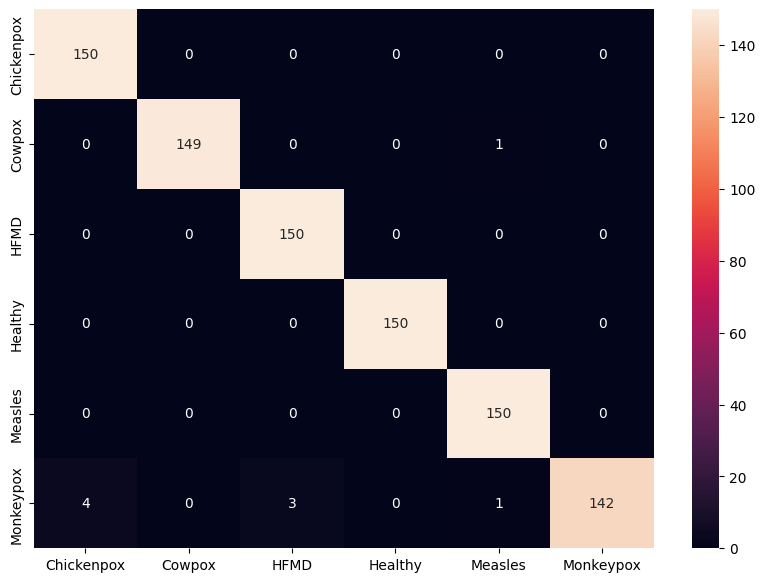

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Chickenpox', 'Cowpox', 'HFMD','Healthy','Measles','Monkeypox']],
                  columns = [i for i in ['Chickenpox', 'Cowpox', 'HFMD','Healthy','Measles','Monkeypox']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

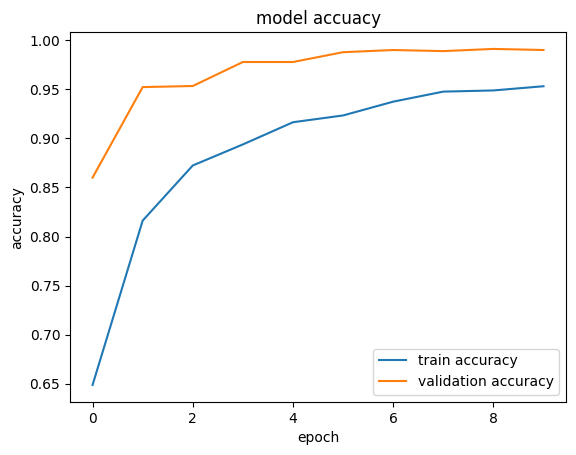

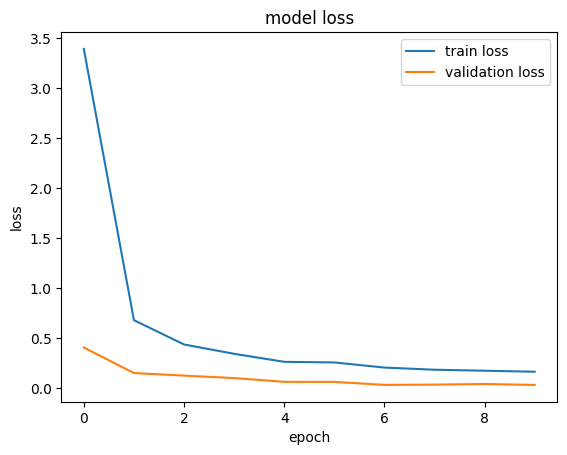

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()